In [4]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/perrypetra-wong/Dropbox/Thinkful/Lessons/Capstone/GoogleNews-vectors-negative300.bin', binary=True)
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.decomposition import PCA
shows = pd.read_pickle("no_na_pre2017_v4.pkl")

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

As we know from the prior notebook, very little learning came from trying to train NLP models on the original training data. If this is a shortcoming of having too few documents to train on, we can instead use a pretrained model for potentially better results. Let's see if adding word2vec vectorization based on the Google News pretrained model in particular does any better. We know that there's numerous ways to incorporate a word2vec model into a feature space, so we'll try the following:
- Taking simple averages of vectors, and then average those for each document. This will result in one number to represent each text entry (tagline, synopsis, or imdb plot)
- Taking the element-wise minimum and maximum of the vectors in each document (for a feature space of 600 per observation)
    - This idea came from [this Elsevier paper](https://arxiv.org/pdf/1607.00570.pdf)
- Taking the element-wise mean of the vectors in each document (for a feature space of 300 per observation)

## Cut #1: Averaging word vectors in total

In [4]:
import string

def word2vectorizer(wordstring):
    
    wordvecs = []
    
    # In case of null
    if isinstance(wordstring,float):
        wordvecs = 0
    else:
        punct_remover = str.maketrans('', '', string.punctuation)
        
        # Removing punctuation and splitting apart words
        punct_stripped = wordstring.translate(punct_remover)
        wordlist = punct_stripped.split()

        # If word is in Google model, add it its corresponding vec to our running list
        for word in wordlist:
            if word in model:
                wordvecs.append(model[word].mean())

        # Make zero if we didn't have any matches whatsoever, otherwise average all the mean vecs
        if len(wordvecs) == 0:
            wordvecs = 0
        else:
            wordvecs = np.mean(wordvecs)
    
    return wordvecs

In [5]:
wordvecinfo = pd.DataFrame({'tagline_vec': shows['tagline'].apply(word2vectorizer)
                            ,'synopsis_vec': shows['synopsis'].apply(word2vectorizer)
                            ,'imdb_plot_vec': shows['imdb_plot'].astype('O').apply(word2vectorizer)})

In [6]:
wordvecinfo = pd.read_pickle("wordvecmeans.pkl")
wordvecinfo.head()

,imdb_plot_vec,synopsis_vec,tagline_vec
0,0.000534,-0.000154,0.000360
1,-0.002832,-0.000304,-0.002745
2,-0.001667,-0.003027,-0.003814
3,-0.004004,-0.001980,-0.002769
4,0.000309,0.000269,0.001055


Let's perform some supervised modeling on the results. Our baseline is again ~57%.

### Supervised models w/ just word2vec aggregate means

In [7]:
# DF to store results
word2vec_model_comp = pd.DataFrame(columns=['accuracy','precision','recall'])

In [9]:
shows = shows.join(wordvecinfo)
#shows.to_pickle('cleaned_dataset_v5.pkl')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


In [10]:
X = shows.iloc[:,-3:]
Y = shows['two_season_cancel']

In [11]:
lrc = LogisticRegression()

params = {'C': np.power(10,np.arange(-10,10).astype(float))
          ,'penalty':['l1','l2']}

GS_LRC = GridSearchCV(lrc,param_grid=params,scoring='accuracy')

GS_LRC.fit(X,Y)
lrc_score = GS_LRC.best_score_
print('LRC accuracy (grid-searched): {0:.2%}'.format(lrc_score))

LRC accuracy (grid-searched): 57.90%


In [83]:
# Successive gridsearching
rfc = RandomForestClassifier()

rf_params = {
    'n_estimators':np.arange(25,45,5),
    'max_features':['auto','log2','sqrt',None],
    'max_depth':np.append(np.array([None]),np.arange(2,11,1)),
    'min_samples_leaf':np.arange(1,5),
}

GS_RFC = GridSearchCV(rfc,param_grid=rf_params,scoring='accuracy')

GS_RFC.fit(X,Y)
rfc_score = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_score))

RFC accuracy (grid-searched): 58.36%


In [84]:
# Successive gridsearching
gbc = GradientBoostingClassifier()
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(10,40,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy')

GS_GBC.fit(X,Y)
gbc_score = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_score))

GBC accuracy (grid-searched): 58.43%


Results are pretty poor, but let's see how well this plays with our high performing supervised model when it is included.

### Supervised models with aggregate word2vec means and our feature set from earlier models
##### GBC

In [12]:
gbc = GradientBoostingClassifier()

X = pd.concat([pd.get_dummies(shows[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O')))\
               ,shows[['risky_2season','start_year','quarter','month','imdb_plot_vec','synopsis_vec','tagline_vec']]],axis=1)
Y = shows['two_season_cancel']

In [13]:
# Successive gridsearching (which is why params might not match what's elsewhere)
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(10,40,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy')

In [14]:
GS_GBC.fit(X,Y)
gbc_acc = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_acc))

GBC accuracy (grid-searched): 72.95%


In [15]:
GS_GBC.best_params_

{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 30}

In [16]:
#Storing results
gbc_prec = cross_val_score(GS_GBC.best_estimator_,X,Y,scoring='precision').mean()
gbc_rec = cross_val_score(GS_GBC.best_estimator_,X,Y,scoring='recall').mean()

word2vec_model_comp.loc['GBC w/ aggregate means'] = [gbc_acc,gbc_prec,gbc_rec]
word2vec_model_comp

,accuracy,precision,recall
GBC w/ aggregate means,0.729483,0.688699,0.664395


In [30]:
joblib.dump(GS_GBC,"Extras/GS_wv_gbc.pkl")

['Extras/GS_wv_gbc.pkl']

This represents barely any improvement vs. our original model. Let's see if the decently performing RFC or SVM did any better.

##### RFC

In [18]:
rfc = RandomForestClassifier()

# Successive gridsearching
rf_params = {
    'n_estimators':np.arange(25,45,5),
    'max_features':['auto','log2','sqrt',None],
    'max_depth':np.append(np.array([None]),np.arange(2,11,1)),
    'min_samples_leaf':np.arange(1,5),
}

GS_RFC = GridSearchCV(rfc,param_grid=rf_params,scoring='accuracy',refit=True)

In [26]:
GS_RFC.fit(X,Y)
rfc_acc = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_acc))
print(GS_RFC.best_params_)

RFC accuracy (grid-searched): 72.80%
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 25}


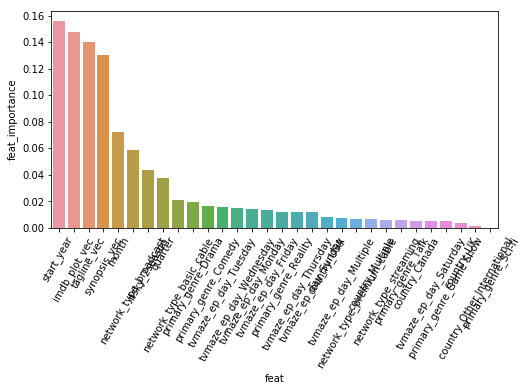

In [27]:
GS_RFC.estimator.fit(X,Y)

feat_impt_df = pd.DataFrame(data={'feat':X.columns,'feat_importance':GS_RFC.estimator.feature_importances_}).sort_values('feat_importance',ascending=False)
order = feat_impt_df.feat

plt.figure(figsize=(8,4))
sns.barplot(x='feat',y='feat_importance',data=feat_impt_df,order=order)
plt.xticks(rotation=60)
plt.show()

In [28]:
#Storing results
rfc_prec = cross_val_score(GS_RFC.best_estimator_,X,Y,scoring='precision').mean()
rfc_rec = cross_val_score(GS_RFC.best_estimator_,X,Y,scoring='recall').mean()

word2vec_model_comp.loc['RFC w/ aggregate means'] = [rfc_acc,rfc_rec,rfc_prec]
word2vec_model_comp

,accuracy,precision,recall
GBC w/ aggregate means,0.729483,0.688699,0.664395
RFC w/ aggregate means,0.727964,0.605476,0.671314


In [29]:
# Saving to pickle
joblib.dump(GS_RFC,"Extras/GS_wv_rfc.pkl")

['Extras/GS_wv_rfc.pkl']

##### SVM

In [33]:
from sklearn.preprocessing import MinMaxScaler

svc = SVC()

# Need to use different inputs vs. RFC/GB

X = pd.concat([pd.get_dummies(shows[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O'))).reset_index(drop=True)\
               ,shows[['risky_2season','start_year']].reset_index(drop=True)\
           ,pd.DataFrame(MinMaxScaler().fit_transform(shows[['quarter','month']])\
                         ,columns=['quarter','month'])],axis=1)

# Successive gridsearching
svc_params = {
    'C':np.power(10,np.arange(-2,2).astype(float)),
    'kernel':['rbf']
}

GS_SVC = GridSearchCV(svc,param_grid=svc_params,scoring='accuracy',refit=True)

GS_SVC.fit(X,Y)
svc_acc = GS_SVC.best_score_

#Storing results
svc_prec = cross_val_score(GS_SVC.best_estimator_,X,Y,scoring='precision').mean()
svc_rec = cross_val_score(GS_SVC.best_estimator_,X,Y,scoring='recall').mean()

word2vec_model_comp.loc['SVM Classifier w/ aggregate means'] = [svc_acc,svc_prec,svc_rec]
word2vec_model_comp

,accuracy,precision,recall
GBC w/ aggregate means,0.729483,0.688699,0.664395
RFC w/ aggregate means,0.727964,0.605476,0.671314
SVM Classifier w/ aggregate means,0.723404,0.678964,0.664367


In [39]:
# Saving to pickle
joblib.dump(GS_SVC,"Extras/GS_wv_svc.pkl")

['Extras/GS_wv_svc.pkl']

Looks like all of them are performing pretty similarly, with very little benefit being yielded.

## Cut #2 - Taking the min and max vectors concatenated, element-wise

In [103]:
import string

def word2vectorizer_minmax(wordstring):
    
    wordvecs = []
    
    # In case of null
    if isinstance(wordstring,float):
        wordvecs = [0]*300*2
    else:
        punct_remover = str.maketrans('', '', string.punctuation)
        
        # Removing punctuation and splitting apart words
        punct_stripped = wordstring.translate(punct_remover)
        wordlist = punct_stripped.split()

        # If word is in Google model, add it its corresponding vec to our running list
        for word in wordlist:
            if word in model:
                wordvecs.append(model[word])

        # Make zero if we didn't have any matches whatsoever, otherwise average all the mean vecs
        if len(wordvecs) == 0:
            wordvecs = [0]*300*2
        else:
            vecmin = np.min(wordvecs,axis=0)
            vecmax = np.max(wordvecs,axis=0)
            wordvecs = np.concatenate((vecmin,vecmax),axis=0)
    
    return wordvecs

In [106]:
tagline_el_minmax = pd.DataFrame(shows['tagline'].astype('O').apply(word2vectorizer_minmax).values.tolist())
synopsis_el_minmax = pd.DataFrame(shows['synopsis'].astype('O').apply(word2vectorizer_minmax).values.tolist())
imdbplot_el_minmax = pd.DataFrame(shows['imdb_plot'].astype('O').apply(word2vectorizer_minmax).values.tolist())
tot_el_minmax = pd.concat([tagline_el_minmax,synopsis_el_minmax,imdbplot_el_minmax],axis=1)

In [110]:
X = tagline_el_minmax

This is an opportunity for dimensionality reduction given the very high number of features.

In [122]:
performance=[]
rng = np.arange(10,200,10)
for x in rng:
    pca = PCA(n_components=x)
    X_pca = pca.fit_transform(X)
    performance.append(cross_val_score(lrc,X_pca,Y).mean())

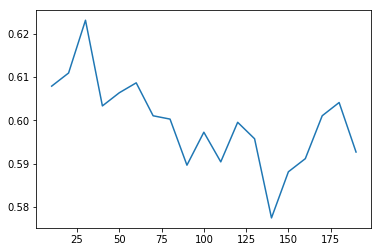

In [123]:
plt.plot(rng,performance)
plt.show()

In [125]:
rng[np.argmax(performance)]

30

In [126]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X)

In [127]:
cross_val_score(gbc,X_pca,Y)

array([0.64236902, 0.58769932, 0.57762557])

In [113]:
print(cross_val_score(gbc,tagline_el_minmax,Y))
print(cross_val_score(gbc,synopsis_el_minmax,Y))
print(cross_val_score(gbc,imdbplot_el_minmax,Y))

[0.59225513 0.51480638 0.55479452]
[0.58314351 0.53530752 0.56164384]
[0.60592255 0.56264237 0.57077626]


We're getting fairly mediocre results using the min-max vectors, so this probably isn't our best option. Let's return to optimize option #2, the element-wise means.

## Cut #3: Let's instead try the elementwise vector mean.

In [6]:
import string
import nltk

def word2vectorizer_elementmean(wordstring):
    
    wordvecs = []
    
    # In case of null
    if isinstance(wordstring,float):
        wordvecs = [0]*300
    else:
        punct_remover = str.maketrans('', '', string.punctuation)
        
        # Removing punctuation and splitting apart words
        # Optionally, remove stopwords and stem words
        punct_stripped = wordstring.translate(punct_remover)
        punct_stripped = gensim.parsing.preprocessing.remove_stopwords(punct_stripped)
        #punct_stripped = gensim.parsing.stem_text(punct_stripped)
        wordlist = punct_stripped.split()

        # If word is in Google model, add it its corresponding vec to our running list
        for word in wordlist:
            if word in model:
                wordvecs.append(model[word])

        # Make zero if we didn't have any matches whatsoever, otherwise average all the mean vecs
        if len(wordvecs) == 0:
            wordvecs = [0]*300
        else:
            wordvecs = np.mean(wordvecs,axis=0)
    
    return wordvecs

In [7]:
tagline_el_means = pd.DataFrame(shows['tagline'].astype('O').apply(word2vectorizer_elementmean).values.tolist())
synopsis_el_means = pd.DataFrame(shows['synopsis'].astype('O').apply(word2vectorizer_elementmean).values.tolist())
imdbplot_el_means = pd.DataFrame(shows['imdb_plot'].astype('O').apply(word2vectorizer_elementmean).values.tolist())
tot_el_means = pd.concat([tagline_el_means,synopsis_el_means,imdbplot_el_means],axis=1)
tot_el_means.to_pickle("Extras/tot_el_means.pkl")

In [8]:
X = tot_el_means
Y = shows['two_season_cancel']

In [12]:
lrc = LogisticRegression()

params = {'C': np.power(10,np.arange(-10,10).astype(float))
          ,'penalty':['l1','l2']}

GS_LRC = GridSearchCV(lrc,param_grid=params,scoring='accuracy',refit=True)

GS_LRC.fit(X,Y)
lrc_score = GS_LRC.best_score_
print('LRC accuracy (grid-searched): {0:.2%}'.format(lrc_score))

LRC accuracy (grid-searched): 60.03%


In [13]:
GS_LRC.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [ ]:
# Successive gridsearching
rfc = RandomForestClassifier()

rf_params = {
    'n_estimators':np.arange(25,45,5),
    'max_features':['auto','log2','sqrt',None],
    'max_depth':np.append(np.array([None]),np.arange(2,11,1)),
    'min_samples_leaf':np.arange(1,5),
}

GS_RFC = GridSearchCV(rfc,param_grid=rf_params,scoring='accuracy',refit=True)

GS_RFC.fit(X,Y)
rfc_score = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_score))

In [17]:
rfc = RandomForestClassifier(n_estimators=300)

In [18]:
cross_val_score(rfc,X,Y)

array([0.62642369, 0.60820046, 0.58219178])

In [136]:
cross_val_score(gbc,X,Y)

array([0.59908884, 0.5808656 , 0.56621005])

We're dealing with a very high dimensional dataset, especially given its length. This could again be an opportunity to use PCA.

In [38]:
pca = PCA(n_components=40)

In [108]:
X_pca = pca.fit_transform(X)

In [109]:
cross_val_score(lrc,X_pca,Y)

array([0.64464692, 0.59681093, 0.57762557])

In [22]:
performance=[]
rng = np.arange(1,900,25)
for x in rng:
    pca = PCA(n_components=x)
    X_pca = pca.fit_transform(X)
    performance.append(cross_val_score(lrc,X_pca,Y).mean())

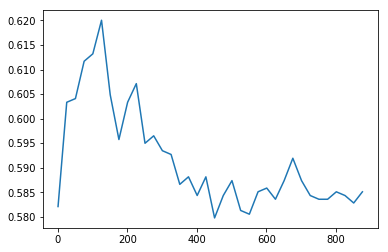

In [23]:
plt.plot(rng,performance)
plt.show()

Iterating...

In [24]:
performance=[]
rng = np.arange(20,80,1)
for x in rng:
    pca = PCA(n_components=x)
    X_pca = pca.fit_transform(X)
    performance.append(cross_val_score(lrc,X_pca,Y).mean())

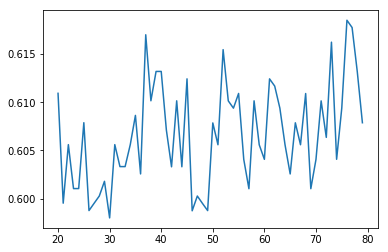

In [25]:
plt.plot(rng,performance)
plt.show()

In [26]:
rng[np.argmax(performance)]

76

The best option is somewhere between 35 and 80, but frankly where within that range is best is pretty unclear, and it's generally not a good idea to increase the dimensionality of a feature set for very marginal returns in training accuracy. Let's instead reference the eigenvectors and eigenvalues to try to decide a cutoff.

In [110]:
# Picking 100 to look at eigens
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

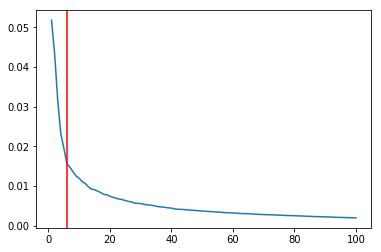

In [112]:
plt.plot(range(1,101), pca.explained_variance_ratio_)
plt.axvline(x=6,color='red')
plt.show()

Using this "elbow" at around 6, lets' see what kind of results we can get with different models.

In [14]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

In [15]:
lrc = LogisticRegression(penalty='l1',C=1e20)

In [16]:
cross_val_score(lrc,X_pca,Y)

array([0.59225513, 0.59681093, 0.59360731])

In [19]:
gbc = GradientBoostingClassifier()

In [20]:
# Successive gridsearching
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(10,40,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy')

In [21]:
GS_GBC.fit(X_pca,Y)
gbc_score = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_score))

GBC accuracy (grid-searched): 60.18%


In [22]:
GS_GBC.best_params_

{'learning_rate': 0.4,
 'loss': 'exponential',
 'max_depth': 2,
 'n_estimators': 20}

Trying again with more like 40 PCA features.... <br>
Log Regression...

In [23]:
pca = PCA(n_components=40)
X_pca = pca.fit_transform(X)

In [24]:
lrc = LogisticRegression()

params = {'C': np.power(10,np.arange(-10,10).astype(float))
          ,'penalty':['l1','l2']}

GS_LRC = GridSearchCV(lrc,param_grid=params,scoring='accuracy',refit=True)

GS_LRC.fit(X_pca,Y)
lrc_score = GS_LRC.best_score_
print('LRC accuracy (grid-searched): {0:.2%}'.format(lrc_score))

LRC accuracy (grid-searched): 61.17%


In [25]:
GS_LRC.best_params_

{'C': 1.0, 'penalty': 'l2'}

RFC

In [26]:
rfc = RandomForestClassifier()

# Successive gridsearching
rf_params = {
    'n_estimators':np.arange(25,45,5),
    'max_features':['auto','log2','sqrt',None],
    'max_depth':np.append(np.array([None]),np.arange(2,11,1)),
    'min_samples_leaf':np.arange(1,5),
}

GS_RFC = GridSearchCV(rfc,param_grid=rf_params,scoring='accuracy',refit=True)

In [27]:
GS_RFC.fit(X_pca,Y)
rfc_em_acc = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_em_acc))

RFC accuracy (grid-searched): 61.40%


In [38]:
joblib.dump(GS_RFC,"Extras/RFC_w2v_em_only.pkl")
pd.DataFrame(X_pca).to_pickle("Extras/40pca_w2v_em.pkl")

GBC

In [19]:
gbc = GradientBoostingClassifier()

In [20]:
# Successive gridsearching
gb_params = {
    'loss':['deviance','exponential'],
    'learning_rate':np.arange(0.1,1,0.1),
    'n_estimators':np.arange(10,40,10),
    'max_depth':np.append(np.array([None]),np.arange(1,11,1)),
}

GS_GBC = GridSearchCV(gbc,param_grid=gb_params,scoring='accuracy')

In [21]:
GS_GBC.fit(X_pca,Y)
gbc_score = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_score))

GBC accuracy (grid-searched): 60.18%


In [22]:
GS_GBC.best_params_

{'learning_rate': 0.4,
 'loss': 'exponential',
 'max_depth': 2,
 'n_estimators': 20}

We still seem to be hovering around 60-62% performance depending on the specific model we use and various parameters. Let's see what happens when we include the original supervised modeling information.

In [40]:
pca = PCA(n_components=6)
X_pca = pd.DataFrame(pca.fit_transform(tot_el_means))

In [41]:
X = pd.concat([pd.get_dummies(shows[['network_type','country','tvmaze_ep_day','primary_genre']].apply(lambda x: x.astype('O'))).reset_index(drop=True)\
               ,shows[['risky_2season','start_year','quarter','month']].reset_index(drop=True),X_pca],axis=1)

In [42]:
# Confirming that our feature set was created correctly
X.head()

,network_type_basic_cable,network_type_broadcast,network_type_premium_cable,network_type_streaming,country_Canada,country_Multiple,country_Other International,country_UK,country_USA,tvmaze_ep_day_Friday,...,risky_2season,start_year,quarter,month,0,1,2,3,4,5
0,0,1,0,0,0,0,0,0,1,0,...,1,2010,3,9,-0.076120,-0.348940,-0.043796,-0.119944,-0.139163,0.028753
1,0,1,0,0,0,1,0,0,0,0,...,1,2011,3,7,0.595556,0.158800,-0.327023,0.249426,-0.440472,0.061161
2,1,0,0,0,0,0,0,0,1,1,...,0,2015,1,1,-0.187184,0.303944,-0.152543,0.360604,-0.011317,0.113071
3,1,0,0,0,0,0,0,0,1,0,...,1,2009,2,6,0.119660,-0.233015,-0.092817,0.165448,0.511842,0.350773
4,0,1,0,0,0,0,0,0,1,0,...,1,2012,4,12,-0.164732,-0.315039,0.067494,0.022872,0.095439,-0.050426


In [44]:
GS_GBC.fit(X,Y)
gbc_em_acc = GS_GBC.best_score_
print('GBC accuracy (grid-searched): {0:.2%}'.format(gbc_em_acc))

GBC accuracy (grid-searched): 72.80%


In [45]:
# Storing results
gbc_em_prec = cross_val_score(GS_GBC.best_estimator_,X,Y,scoring='precision').mean()
gbc_em_rec = cross_val_score(GS_GBC.best_estimator_,X,Y,scoring='recall').mean()

word2vec_model_comp.loc['GBC w/ element means'] = [gbc_em_acc,gbc_em_prec,gbc_em_rec]
word2vec_model_comp

,accuracy,precision,recall
GBC w/ aggregate means,0.729483,0.688699,0.664395
RFC w/ aggregate means,0.727964,0.605476,0.671314
SVM Classifier w/ aggregate means,0.723404,0.678964,0.664367
GBC w/ element means,0.727964,0.688395,0.659029


In [53]:
joblib.dump(GS_GBC,"Extras/GS_wv_em_gbc.pkl")

['Extras/GS_wv_em_gbc.pkl']

In [56]:
word2vec_model_comp.to_pickle("Extras/word2vec_model_comp.pkl")

No improvement for our GB Classifier.

##### RFC

In [50]:
GS_RFC.fit(X,Y)
rfc_em_acc = GS_RFC.best_score_
print('RFC accuracy (grid-searched): {0:.2%}'.format(rfc_em_acc))

RFC accuracy (grid-searched): 72.42%


In [51]:
GS_RFC.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 35}

In [52]:
# Storing results
rfc_em_prec = cross_val_score(GS_RFC.best_estimator_,X,Y,scoring='precision').mean()
rfc_em_rec = cross_val_score(GS_RFC.best_estimator_,X,Y,scoring='recall').mean()

word2vec_model_comp.loc['RFC w/ element means'] = [rfc_em_acc,rfc_em_prec,rfc_em_rec]
word2vec_model_comp

,accuracy,precision,recall
GBC w/ aggregate means,0.729483,0.688699,0.664395
RFC w/ aggregate means,0.727964,0.605476,0.671314
SVM Classifier w/ aggregate means,0.723404,0.678964,0.664367
GBC w/ element means,0.727964,0.688395,0.659029
RFC w/ element means,0.724164,0.670723,0.601853


In [54]:
joblib.dump(GS_RFC,"Extras/GS_wv_em_rfc.pkl")

['Extras/GS_wv_em_rfc.pkl']

##### SVM

In [56]:
from sklearn.preprocessing import MinMaxScaler

svc = SVC()

# Successive gridsearching
svc_params = {
    'C':np.power(10,np.arange(-2,2).astype(float)),
    'kernel':['rbf']
}

GS_SVC = GridSearchCV(svc,param_grid=svc_params,scoring='accuracy',refit=True)

GS_SVC.fit(X,Y)
svc_em_acc = GS_SVC.best_score_

SVC_pred = GS_SVC.predict(X)

svc_em_prec = cross_val_score(GS_SVC.best_estimator_,X,Y,scoring='precision').mean()
svc_em_rec = cross_val_score(GS_SVC.best_estimator_,X,Y,scoring='recall').mean()

word2vec_model_comp.loc['SVM Classifier w/ element means'] = [svc_em_acc,svc_em_prec,svc_em_rec]
word2vec_model_comp

,accuracy,precision,recall
GBC w/ aggregate means,0.729483,0.688699,0.664395
RFC w/ aggregate means,0.727964,0.605476,0.671314
SVM Classifier w/ aggregate means,0.723404,0.678964,0.664367
GBC w/ element means,0.727964,0.688395,0.659029
RFC w/ element means,0.724164,0.670723,0.601853
SVM Classifier w/ element means,0.718845,0.680436,0.637590


In [57]:
joblib.dump(GS_SVC,"Extras/GS_wv_em_svc.pkl")

['Extras/GS_wv_em_svc.pkl']

# Cut #4 - Custom Bagging

As we saw, these models all performed quite poorly when added to our original supervised feature set. I doubt at this point, given the minimal learning enabled by the word2vec features alone, that they'll be able to add much to our final supervised solution regardless of the configuration. But, just to be thorough, there is another way to add these features to our model other than simply featuring them as inputs in our highest performing model from the previous exercise. That is to create a custom bagging solution, wherein our best word2vec model gets a weighted vote in the final outcome along with the supervised model, which is run separately.

In [63]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
kf = KFold(n_splits=3)

In [93]:
# Reloading our best models
GS_GBC = joblib.load("Extras/GS_GBC.pkl")
w2v_rfc = joblib.load("Extras/RFC_w2v_em_only.pkl")
GS_SVC = joblib.load("Extras/GS_svc.pkl")

X = pd.read_pickle("Extras/best_feat_x")
X_pca = pd.read_pickle("Extras/40pca_w2v_em.pkl")
Y = pd.read_pickle("Extras/y")

In [124]:
def CustomBagging(X,Y,model1,model2,w2v_model,weight1,weight2,weight3):
    
    train_ind = []
    test_ind = []
    accuracies = []

    for train,test in kf.split(X):
        train_ind.append(train)
        test_ind.append(test)
      
    print('Fold Accuracies:')
    for train,test in zip(train_ind,test_ind):
        
        # Train base supervised model
        x_train = X.iloc[train]
        y_train = Y.iloc[train]
        
        model1.best_estimator_.fit(x_train,y_train)
        
        # Train next best supervised model
        
        model2.best_estimator_.fit(x_train,y_train)
        
        # Train word2vec model
        x_w2v_train = X_pca.iloc[train]
        y_train = Y.iloc[train]
        
        w2v_model.best_estimator_.fit(x_w2v_train,y_train)
        
        # Make predictions with base supervised model and next best
        x_test = X.iloc[test]
        y_test = Y.iloc[test]
        
        y_pred = model1.best_estimator_.predict(x_test)
        y_pred_next = model2.best_estimator_.predict(x_test)
        
        # Make predictions with w2v
        x_w2v_test = X_pca.iloc[test]
        y_pred_w2v = w2v_model.best_estimator_.predict(x_w2v_test)

        # Weight the predictions
        full_pred = np.round((y_pred*weight1) + (y_pred_next*weight2) + (y_pred_w2v*weight3))
        
        accuracy = metrics.accuracy_score(full_pred,y_test)
        accuracies.append(accuracy)
        
        #print(y_pred,y_pred_next,y_pred_w2v)
        print(accuracy)
        
    print('\nMean Accuracy: {}'.format(np.mean(accuracies)))

In [125]:
CustomBagging(X,Y,GS_GBC,GS_SVC,w2v_rfc,(1/3),(1/3),(1/3))

Fold Accuracies:
0.7403189066059226
0.6765375854214123
0.7420091324200914

Mean Accuracy: 0.7196218748158087


In [126]:
CustomBagging(X,Y,GS_GBC,GS_SVC,w2v_rfc,(0.5),(1/4),(1/4))

Fold Accuracies:
0.7403189066059226
0.6765375854214123
0.7420091324200914

Mean Accuracy: 0.7196218748158087


In [128]:
CustomBagging(X,Y,GS_GBC,GS_SVC,w2v_rfc,(1/2),(1/4),(1/4))

Fold Accuracies:
0.7403189066059226
0.6765375854214123
0.7442922374429224

Mean Accuracy: 0.7203829098234191


We're seeing basically the same thing. No matter how we combine it, the word2vec feature space is just not helping us that much. We could come up with a different bagging solution that involves probabilities, but given the weak learning of the word2vec solution, I highly doubt this will be any more fruitful than what we've already tried. Sad! We'll try ONE more thing in the next notebook - an application of these word2vec mappings in a keras neural net.